# OCSMesh Tutorial

Import module required throughout this tutorial

In [1]:
from copy import deepcopy
from pathlib import Path 
import requests
import tempfile
from datetime import datetime, timedelta
import zipfile

import geopandas as gpd
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import numpy as np
from pyproj import CRS
from shapely import geometry

import ocsmesh
import pyschism
import pyschism.driver

Define constants, paths, useful datasets, functions etc.

In [2]:
def plot_mesh_edge(msh_t_obj, ax=None, **kwargs):
    crd = msh_t_obj.vert2['coord']
    cnn = msh_t_obj.tria3['index']
    
    if ax == None:
        fig, ax = plt.subplots()
    ax.triplot(crd[:, 0], crd[:, 1], cnn, **kwargs)
    ax.set_aspect(1)
    return ax
    
def plot_mesh_vals(msh_t_obj, ax=None, colorbar=True, **kwargs):
    crd = msh_t_obj.vert2['coord']
    cnn = msh_t_obj.tria3['index']
    val = msh_t_obj.value.flatten()
    
    if ax == None:
        fig, ax = plt.subplots()
    mappable = ax.tricontourf(crd[:, 0], crd[:, 1], cnn, val, **kwargs)
    if colorbar:
        plt.colorbar(mappable)
    ax.set_aspect(1)

    return ax

<AxesSubplot: >

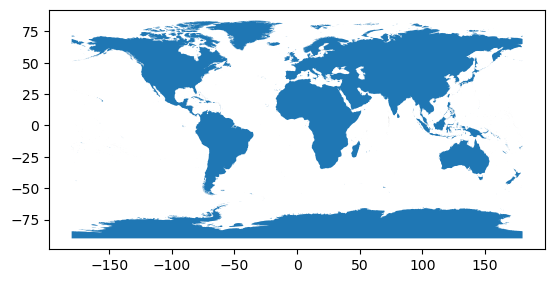

In [3]:
data = Path('./data')

#gdf_countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf_countries = gpd.GeoSeries(NaturalEarthFeature(category='physical', scale='10m', name='land').geometries(), crs=4326)

gdf_countries.plot()

If you're using a machine without internet access, e.g. compute nodes, then you need to download the shapefiles by `cartopy_feature_download.py physical` from another machine and then copy it from `~/.local/share/cartopy/shapefiles/natural_earth/physical/ne_10m_land.*`


OCSMesh generates the unstructured mesh within the **Geometry** and based on the sizes defined by the **Size function**. It uses Jigsaw meshing engine through its Python wrapper `jigsawpy`.
The role of the modeler is to create these two objects based on the **mesh requirements** using tools available within or even outside `ocsmesh`.

## Geometry
In the context of mesh generation using `ocsmesh`, *geometry* is the defintion of the region or domain to be meshed.
There are **3** basic ways of defining the geometry. There's also a **4th** method which is in essence *combination* of multiple of the basic types!
The jobs of OCSMesh's geometry object is to process the inputs and user specifications and eventually provide **polygons** to be meshed to the meshing engine (Jigsaw). This output polygon from the geometry is of a custom type defined by Jigsaw.

All geometry object types are created by passing the correct type of argument to the `ocsmesh.Geom` factory class. It is also possible for the user to directly create specific type of geometry class by creating an `ocsmesh.geom.mesh.MeshGeom` for example.

### Shape based
The most basic way for a user to define the meshing domain (i.e. geometry) is to specify a polygon or list of polygons. This way, the only thing geometry object needs to do is to pass the same input polygon to the mesh engine! The classes that define these objects are `ocsmesh.geom.shapely.PolygonGeom` and `ocsmesh.geom.shapely.MultiPolygonGeom`.

It's important to note that the **format** of input polygon and output polygon of the geometry object are **different**. The input polygon needs to be of type `shapely.geometry.Polygon` or `shapely.geometry.MultiPolygon`. *Shapely* (along with *PyGEOS*) is one the the most commonly used `GEOS` library wrappers in Python; many of the Python packages (e.g. `geopandas`) support Shapely objects, which makes is easier for the user to operate on the shapes until it meets their desired criteria, and then pass it to OCSMesh via `ShapelyGeom`.

Shape-based geometry gives the user full control on how the domain looks like. The user can manipulate the input shape, add or subtract segmets from it and then finally pass it to the `Geom` factory class to retrieve an OCSMesh geometry object:

In [4]:
gdf_oceans = gpd.GeoDataFrame(geometry=[geometry.box(*gdf_countries.total_bounds).difference(gdf_countries.unary_union)], crs=gdf_countries.crs)
roi_box = geometry.box(-74.5, 39.5, -71.5, 41.5)
gdf_roi_domain = gdf_oceans.intersection(roi_box)
geom_obj_1 = ocsmesh.Geom(gdf_roi_domain.unary_union, crs=gdf_roi_domain.crs)

Which we can plot to get the following. Note that `get_multipolygon` method returns a Shapely object, while `msh_t` returns Jigsaw polygon (used for passing info to mesh engine):

<AxesSubplot: >

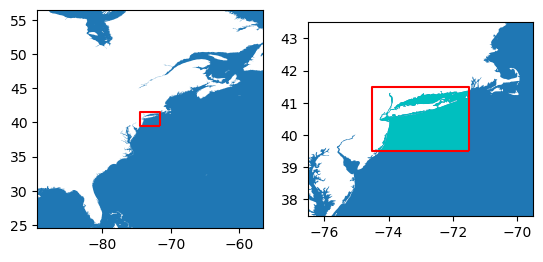

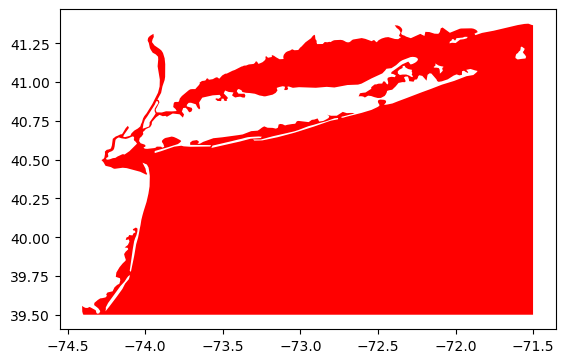

In [5]:
fig_1, axs_1 = plt.subplots(1, 2)

ax = axs_1[0]
gdf_oceans.plot(ax=ax)
gpd.GeoSeries(roi_box).boundary.plot(ax=ax, color='r')
ax.set_xlim(roi_box.bounds[0] - 15, roi_box.bounds[2] + 15)
ax.set_ylim(roi_box.bounds[1] - 15, roi_box.bounds[3] + 15)
ax.set_aspect(1)

ax = axs_1[1]
gdf_oceans.plot(ax=ax)
gpd.GeoSeries(roi_box).boundary.plot(ax=ax, color='r')
gdf_roi_domain.plot(ax=ax, color='c')
ax.set_xlim(roi_box.bounds[0] - 2, roi_box.bounds[2] + 2)
ax.set_ylim(roi_box.bounds[1] - 2, roi_box.bounds[3] + 2)
ax.set_aspect(1)


geom_poly_1 = geom_obj_1.get_multipolygon()
gpd.GeoSeries(geom_poly_1).plot(color='r')

### Mesh based

The next type of geometry definition is by mesh. That means the domain of meshing will be the same as the existing mesh that is passed as input. The class `ocsmesh.geom.mesh.MeshGeom` defines this type of object:

Let's download an example *Shinnecock Inlet* mesh from ADCIRC examples first:

In [6]:
#_tmp = requests.get('https://www.dropbox.com/s/t2e26p11ep0ydx1/shinnecock_inlet_test_case.zip?dl=1')
#with open('shinnecock.zip', 'wb') as fo:
#    fo.write(_tmp.content)

Note that if you're running this notebook on a machine without internet access, you need to download the data separately by `wget https://www.dropbox.com/s/t2e26p11ep0ydx1/shinnecock_inlet_test_case.zip?dl=1 -O data/shinnecock.zip` and before running the notebook and comment the download lines.

In [7]:
#with open(data / 'shinnecock.zip', 'r') as fo:    
#    archive = zipfile.ZipFile(fo, 'r')
#    archive.extract('fort.14')

Now we need to create a *mesh object* and then pass that mesh object to the `Geom` factory to create a geometry object based on mesh:

In [8]:
mesh_obj_2 = ocsmesh.Mesh.open(data/'fort.14', crs=4326)
geom_obj_2 = ocsmesh.Geom(mesh_obj_2)

Now we can draw the mesh and the geometry:

/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/mesh/mesh.py:739: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in polys:


<AxesSubplot: >

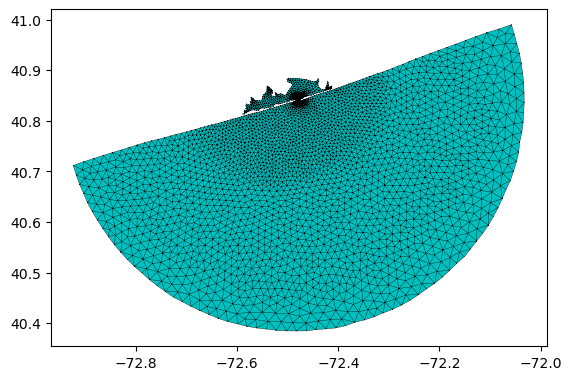

In [9]:
geom_poly_2 = geom_obj_2.get_multipolygon()

ax = gpd.GeoSeries(geom_poly_2).plot(color='c')
plot_mesh_edge(mesh_obj_2, ax=ax, color='k', linewidth=0.25)

### Raster based

Raster based geometry object is the most feature rich type of geometry. The user doesn't have as much control over the exact shape, unlike when using mesh based geom, but rather controls the domain based on specific criteria for which data from raster is used. To demo it, let's download a couple of DEM files first:

In [10]:
ny_cudem_url = [
    "https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n41x00_w074x25_2015v1.tif",
    "https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n41x00_w074x00_2015v1.tif",
    "https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n40x75_w074x25_2015v1.tif",
    "https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n40x75_w074x00_2015v1.tif"
]
ny_cudem = []
for i in ny_cudem_url:
    # Uncomment to download the data
#    _tmp = requests.get(i)
#    with open(filename, 'wb') as fo:
#        fo.write(_tmp.content)
        
    filename = data / i.split('/')[-1]
    ny_cudem.append(filename)

Like before not that data might need to be downloaded before hand using `wget`, e.g. if running on compute nodes

Let's see how do they look:

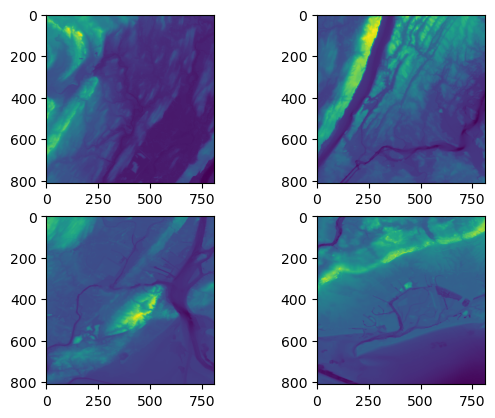

In [11]:
rasters = [ocsmesh.Raster(i) for i in ny_cudem]
# Resample to get results faster!
for rast in rasters:
    rast.resample(scaling_factor=0.1)

fig_2, axs_2 = plt.subplots(2, 2)
for ax, rast in zip(axs_2.ravel(), rasters):
    ax.imshow(rast.get_values())
fig_2.show()

Now let's use these rasters to create geometry. To create `RasterGeom`, the user needs to pass a `ocsmesh.Raster` object to the `Geom` factory class:

<AxesSubplot: >

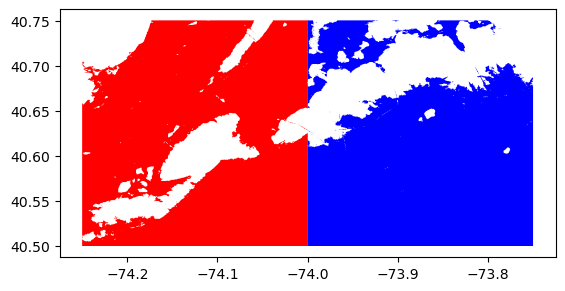

In [12]:
geom_obj_3 = ocsmesh.Geom(rasters[3], zmax=10)
geom_poly_3 = geom_obj_3.get_multipolygon()

geom_obj_4 = ocsmesh.Geom(rasters[2], zmax=15)
geom_poly_4 = geom_obj_4.get_multipolygon()

ax_3 = gpd.GeoSeries(geom_poly_3).plot(color='b')
gpd.GeoSeries(geom_poly_4).plot(color='r', ax=ax_3)

### Collection geometry
But what if we want to create a single geometry from a combination of multiple DEMs, or DEM combined with shape geometry? To achieve this, one can create a geometry object for each fo the DEMs or shape inputs, then get the resulting `Polygon` by `get_multipolygon()`, then union all the shapes and finally create a new goemetry object from the combined shape.

While this is certainly possible, and gives the user more control over all the details, an easier way in generic cases would be to just use `GeomCollector` objects. These objects are created as a result of passing a list of DEMs and potentially other OCSMesh geometry object types to the `Geom` factory class:

/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/ops/combine_geom.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rasters_gdf = rasters_gdf.append(
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/ops/combine_geom.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rasters_gdf = rasters_gdf.append(
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/ops/combine_geom.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rasters_gdf = rasters_gdf.append(
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/ops/combine_geom.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<AxesSubplot: >

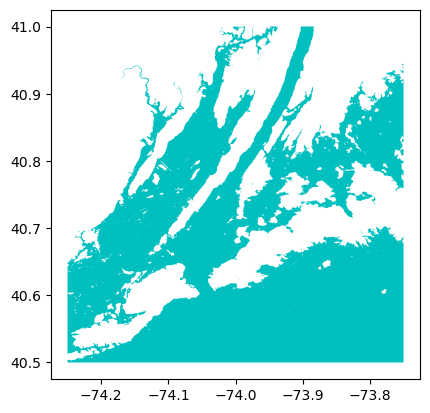

In [13]:
geom_obj_5 = ocsmesh.Geom(rasters, zmax=10)
geom_poly_5 = geom_obj_5.get_multipolygon()

gpd.GeoSeries(geom_poly_5).plot(color='c')

It automatically generates the multipolygon from each input (raster, mesh, and shapes) and then combines all of the polygons to obtain the total domain.

## Size function
Size function specifies the element size at alls locations throughout the domain. The meshing engine uses these specified sizes to guide the refinement and termination of mesh generation process. It's important to note that the generated mesh doesn't necessarily honor all the specified size values, but it gets very close. Generated elements' actual sizes are also constrained by the requested mesh quality criteria as well as the gradient of element size; for example there cannot be a sharp decrease in element edge length if high quality mesh is requested.

If size function is not defined in parts of the domain, Jigasw automatically uses the closes specified size point to generate mesh in that unspecified region.

There are two main ways to define size function: 1. Mesh based and 2. Raster based. There's also a third way (like geometry object) which is a combination of the aforementioned types. Size functions can be created by using `ocsmesh.Hfun` factory class. Similar to `Geom`, this class returns the correct type of size function based on input type.

The responsibility of the size function of either type is to process the input format and generate a size function object in a format appropriate for the mesh engine (Jigsaw). Jigsaw accepts size functions defined in two ways:
1. Size values defined on a grid (regular rectangular coordinate system, i.e. `meshgrid`)
2. Size values defined on the nodes of a "*background*" unstructured mesh

`ocsmesh` size function output `hfun_obj.msh_t()` is of the type **2** above. There are two reasons behind this: 
1. hfun output is always in a projected CRS (since mesh sizes are in meters), while its input is usually in geographic CRS (e.g. epsg:4326 or nad83)
2. Size function defined on unstructured grid can help reduce memory footprint

### Mesh based
As described above the output of size function object is an unstructured mesh. This makes mesh-based hfun the simplest type of size function. `ocsmesh.hfun.mesh.HfunMesh` class defines this type of object. Like before, `Hfun` factory class automatically creates this type of object, if it receives a `ocsmesh.Mesh` object as its first input. Any existing mesh can be used as the background mesh on which sizes are defined:

In [14]:
mesh_obj_3 = ocsmesh.Mesh.open(data/'fort.14', crs=4326)
hfun_obj_1 = ocsmesh.Hfun(mesh_obj_3)

hfun_msh_t_1 = hfun_obj_1.msh_t()

<AxesSubplot: >

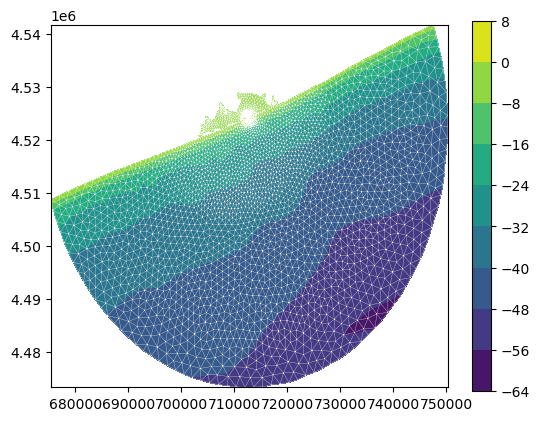

In [15]:
ax_4 = plot_mesh_vals(hfun_msh_t_1)
plot_mesh_edge(hfun_msh_t_1, lw=0.2, color='w', ax=ax_4)

Note that the size function output is in a different CRS than its input mesh; in fact it is the the local UTM based on the location of the center of the hfun extent. Also note that the size function values are still the elevation values from the mesh. To calculate the element edge size based on the actual mesh `size_from_mesh()` method needs to be called:

In [16]:
hfun_obj_2 = deepcopy(hfun_obj_1) # copy to avoid modifying preious objects!
hfun_obj_2.size_from_mesh()

hfun_msh_t_2 = hfun_obj_2.msh_t()

<AxesSubplot: >

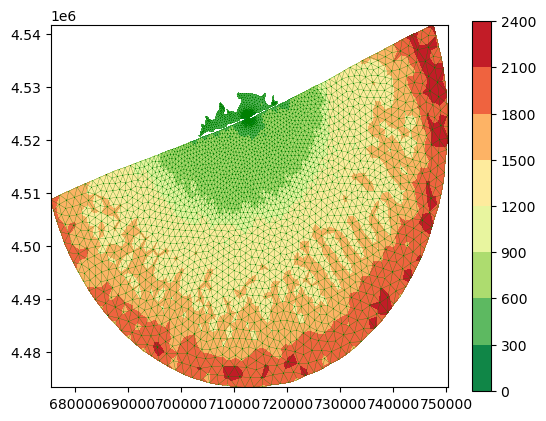

In [17]:
ax_5 = plot_mesh_vals(hfun_msh_t_2, cmap='RdYlGn_r')
plot_mesh_edge(hfun_msh_t_2, lw=0.2, color='g', ax=ax_5)

This approach is usefull for locally modifying the size of an existing mesh an then fully remesh the domain based on the locally modified size function. The values of the mesh based size function can either be manually modified by updating `hfun_obj.msh_t.value` values or using methods defined on this object to refine based on distance from feature lines or polygons. Let's consider some test feature lines and feature polygons for demo purposes (note that in reality these shapes can be provided by cartographers or extracted from accurate DEMs):

In [18]:
test_line_1 = geometry.LineString([
    [6.9e5, 4.51e6],
    [7.1e5, 4.50e6]
])

test_polygon_1 = geometry.Polygon(geometry.LineString([
    [7.2e5, 4.510e6],
    [7.3e5, 4.510e6],
    [7.3e5, 4.515e6],
    [7.2e5, 4.515e6],

]))

<AxesSubplot: >

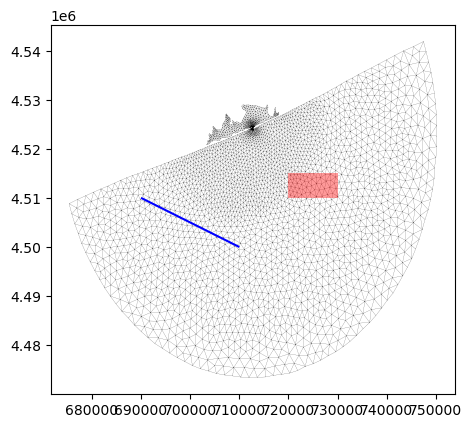

In [19]:
ax_6 = plot_mesh_edge(mesh_obj_3, lw=0.1, color='k')
gpd.GeoSeries(test_line_1).plot(ax=ax_6, color='b')
gpd.GeoSeries(test_polygon_1).plot(ax=ax_6, color='r', alpha=0.4)

Now let's see how it looks if we apply refinement based on distance from these shapes:

In [20]:
hfun_obj_3 = deepcopy(hfun_obj_2) # copy to avoid modifying preious objects!
# Note: hfun_obj_2 already has sizes calculated from mesh!
#hfun_obj_3.size_from_mesh()

hfun_obj_3.add_feature(
    test_line_1,
    expansion_rate=0.001,
    target_size=150,
    nprocs=-1
)

hfun_obj_3.add_patch(
    test_polygon_1,
    expansion_rate=0.001,
    target_size=300
)

hfun_msh_t_3 = hfun_obj_3.msh_t()

/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/hfun/mesh.py:265: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [ply.exterior for ply in multipolygon]
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/hfun/mesh.py:266: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/hfun/mesh.py:367: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  feature = list(feature)
/scratch2/COASTAL/coastal/nosc

<AxesSubplot: >

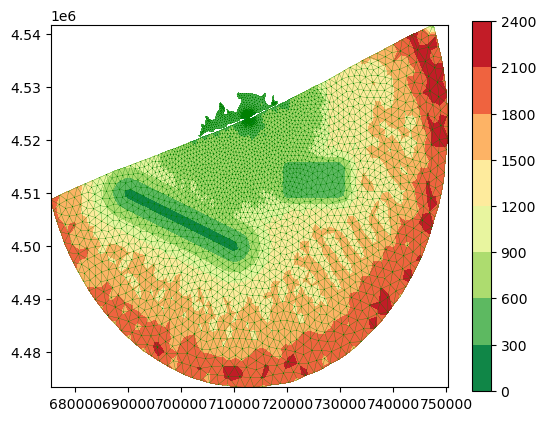

In [21]:
ax_7 = plot_mesh_vals(hfun_msh_t_3, cmap='RdYlGn_r')
plot_mesh_edge(hfun_msh_t_3, lw=0.2, color='g', ax=ax_7)

Note that there are no *predefined* minimum and maximum element sizes here. The addition of refinements determines these min and max. As you'll see this is different for raster based size functions. Also note that the plotted mesh elements are not a mesh that is created based on this hfun, it's the background mesh **on which** the sizes are defined.

### Raster based
It is also possible to use a raster DEM file to define element sizes throughout the domain. Just like geometry, if one passes `Raster` object to `Hfun` factory, a `HfunRaster` object is created. Unlike mesh based hfun -which doesn't have any elevation information in its current implementation- the raster based hfun can use elevation data from the raster to add topography based refinements, in addition to shape based. Internally the raster based hfun refers to two separate rasters:
1. The raster it is created by, which has elevation data
2. The raster where it stores element sizes on
The output of this object (from `hfun_obj.msh_t`) is an unstructured mesh in Jigsaw format.

Unlike mesh based hfun, for this type of hfun min and max can be specified during the construction of the object. Then the target sizes in refinements and constraints are bound by the hmin specified.

Let's now look at a raster based size function:

In [22]:
hfun_obj_4 = ocsmesh.Hfun(rasters[3], hmin=1000, hmax=5000)
hfun_msh_t_4 = hfun_obj_4.msh_t()

<AxesSubplot: >

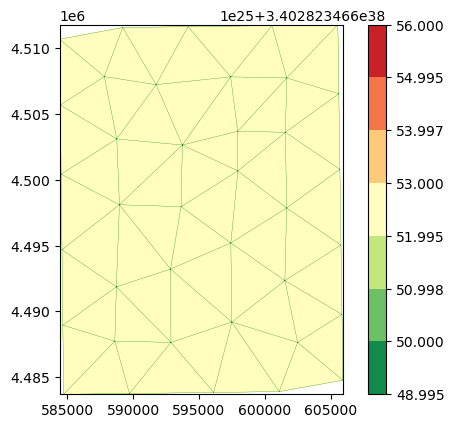

In [23]:
ax_8 = plot_mesh_vals(hfun_msh_t_4, cmap='RdYlGn_r')
plot_mesh_edge(hfun_msh_t_4, lw=0.2, color='g', ax=ax_8)

There are three things to note here:
1. The output is defined on the whole DEM (since no mesh domain is defined on hfun)
2. The output is still in unstructured mesh format.
3. The specified sizes are very large
In fact the unstructured background mesh is created by meshing the DEM extent (projected) using the specified min and max size of `HfunRaster`. The values of the mesh size raster are still `nan` or float-max, so the mesher ignores them and just takes the specified `hmax` size. Then the raster values are interpolated onto the mesh.

This is one of the quirks of OCSMesh. The raster hfun msh_t values are **not** updated unless a refinement is specified! You'll see how it works in the *refinement* section.

#### Refinements
Refinements are mesh size control inputs where in case of overlapping specification (by two different calls, e.g. by contour and by patch), the conflict is resolved by taking the minimum of the two sizes to be the overriding one.

Let's now explore some of the refinement types available for raster-size function

In [24]:
hfun_obj_5 = ocsmesh.Hfun(rasters[3], hmin=100, hmax=2100)
hfun_obj_5.add_contour(level=0, expansion_rate=0.005, target_size=600)
hfun_obj_5.add_constant_value(600, lower_bound=0)

hfun_msh_t_5 = hfun_obj_5.msh_t()

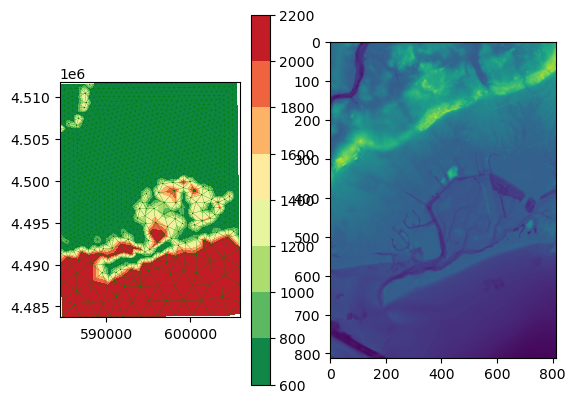

In [25]:
fig_9, axs_9 = plt.subplots(1, 2) 

plot_mesh_vals(hfun_msh_t_5, cmap='RdYlGn_r', ax=axs_9[0])
plot_mesh_edge(hfun_msh_t_5, lw=0.2, color='g', ax=axs_9[0])

axs_9[1].imshow(rast.get_values())
axs_9[1].set_aspect(1.4)

Here we added two types of refinements: 
1. Contour based refinement: Based on the `level` value contour lines are extracted from the input DEM and the specified `target_size` is used as mesh size on that opint along these lines. Then for the rest of the domain the size is calculated based the distance from the closes contour and the `expansion_rate`.
2. Elevation based constant value region: If specified, based on elevation upper and lower bounds sets the specified `value` for all the points within the bounds.

In this specific example, a size of 600m is specified for the coastline (0m) contour and constant value for all the regions with higher elevation. The contour refinement also specified an expansion rate of 0.005. Note that the minimum size of 100m is specified when creating the size function.

#### Constraints
Constraints are mesh size controls that restrict the application of refinements. For example global min and max can be thought of as constraints; if a refinement sets a target smaller than global min, the target is ignored and global min is used instead. The similar logic is used for other types of constraints as well. Currently there's no specific mechanisms to resolve conflicting constraints. The last one added has priority. Let's look at the effects of constraints on the sizes by comparing two cases:

In [26]:
hfun_obj_6_1 = ocsmesh.Hfun(rasters[3], hmin=100, hmax=10000)
hfun_obj_6_1.add_topo_bound_constraint(value=3000, value_type='max')
hfun_obj_6_1.add_topo_bound_constraint(value=500, upper_bound=50, lower_bound=-50, value_type='min', rate=0.01)
hfun_obj_6_1.add_contour(level=0, target_size=100, expansion_rate=0.01)

hfun_obj_6_2 = ocsmesh.Hfun(rasters[3], hmin=100, hmax=10000)
hfun_obj_6_2.add_contour(level=0, target_size=100, expansion_rate=0.01)

hfun_msh_t_6_1 = hfun_obj_6_1.msh_t()
hfun_msh_t_6_2 = hfun_obj_6_2.msh_t()

<AxesSubplot: title={'center': 'Without constraint'}>

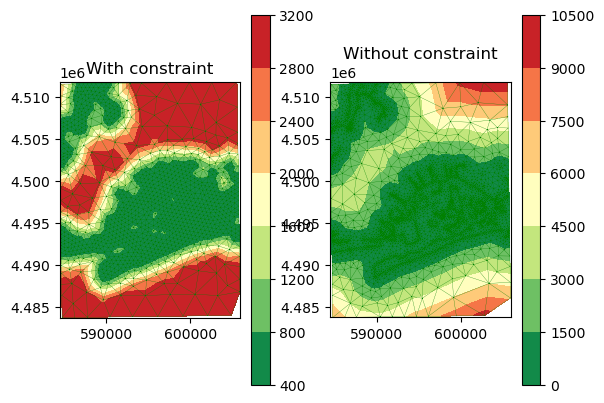

In [27]:
fig_10, axs_10 = plt.subplots(1, 2)

axs_10[0].set_title("With constraint")
plot_mesh_vals(hfun_msh_t_6_1, cmap='RdYlGn_r', ax=axs_10[0])
plot_mesh_edge(hfun_msh_t_6_1, lw=0.2, color='g', ax=axs_10[0])

axs_10[1].set_title("Without constraint")
plot_mesh_vals(hfun_msh_t_6_2, cmap='RdYlGn_r', ax=axs_10[1])
plot_mesh_edge(hfun_msh_t_6_2, lw=0.2, color='g', ax=axs_10[1])

The topo bound constraint is applied to the region between `upper_bound` and `lower_bound` elevations (if provided). The first constraint above doesn't have bonud values, and in effect overwrites the hmax to be `3000`m. The second constraints limits the min element size in the bound of `50` meters above and below the coastlines to be at least `500`m. Note the the applied refinement specifies `100`m, which the global `hmax` allows for, but due to the constraint, we don't see any refinements beyond `~500`m. Note that due to the nature of how size values are applied, there's still a different between global max and min vs the ones applied by constraints. So the constraints values are not necessarily followed exactly

### Collector type
Similar to geometry object, size function can be made up of multiple other size functions or multiple input rasters. The `HfunCollector` class defines this type of object. Collector size function can be created by passing a list to the `Hfun` factory class. `HfunCollector` supports refinements and constraints similar to `HfunRaster`.

In [28]:
hfun_obj_7 = ocsmesh.Hfun(rasters, hmin=100, hmax=10000)
hfun_obj_7.add_topo_bound_constraint(value=3000, value_type='max')
hfun_obj_7.add_topo_bound_constraint(value=500, upper_bound=5, lower_bound=-5, value_type='min', rate=0.01)
hfun_obj_7.add_contour(level=0, target_size=100, expansion_rate=0.01)
hfun_obj_7.add_constant_value(value=200, lower_bound=0)


hfun_msh_t_7 = hfun_obj_7.msh_t()

<AxesSubplot: >

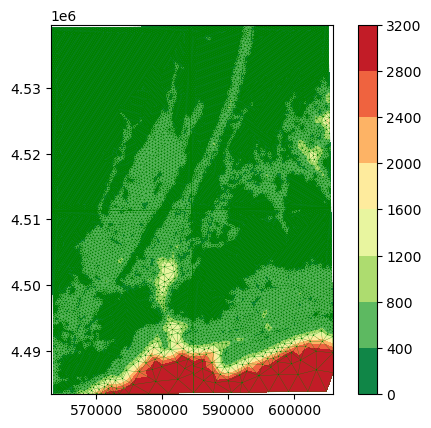

In [29]:
ax_11 = plot_mesh_vals(hfun_msh_t_7, cmap='RdYlGn_r')
plot_mesh_edge(hfun_msh_t_7, lw=0.2, color='g', ax=ax_11)

## Mesh

Let's try to mesh the Shinnecock domain extracted from the original Shinnecock mesh and mesh it using the size function refined by test line and polygon to see how the mesh would look like:

In [30]:
driver_1 = ocsmesh.JigsawDriver(geom_obj_2, hfun_obj_3)
new_mesh_1 = driver_1.run()

<AxesSubplot: >

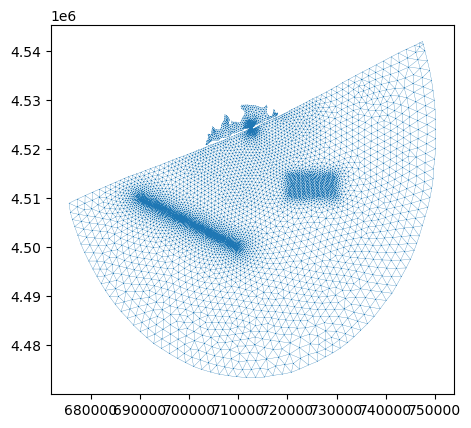

In [31]:
plot_mesh_edge(new_mesh_1.msh_t, lw=0.2)

## Meshing Examples

### Tidal Run Example
#### Domain definition

Following the steps in OCSMesh documentation, let's mesh Shinnecock inlet from stratch. We start from the point of inlet and take the domain to be the `30` $km$ radiums surrounding it. We use GEBCO in addition to the 5 NCEI CUDEM 1/9th of arc DEMs that cover this region. (these need to be pre-downloaded, adjust GEBCO file name depending on the data year)

In [32]:
dem_paths = [
    data / 'gebco_2021_sub_ice_topo_n90.0_s0.0_w-90.0_e0.0.tif',
    data / 'ncei19_n40x75_w073x00_2015v1.tif',
    data / 'ncei19_n41x00_w073x00_2015v1.tif',
    data / 'ncei19_n41x00_w072x75_2015v1.tif',
    data / 'ncei19_n41x00_w072x50_2015v1.tif',
    data / 'ncei19_n41x00_w072x25_2015v1.tif',
]

In [33]:
lon, lat = -72.476, 40.843
custom_crs = CRS.from_string(f'proj=aeqd +lat_0={lat} +lon_0={lon} +datum=WGS84 +units=m')
base_gs = gpd.GeoSeries(geometry.Point([0, 0]).buffer(30e3), crs=custom_crs)

In [34]:
region_box = geometry.box(*geometry.Point(lon, lat).buffer(1).bounds)
gs_region = gpd.GeoSeries(gdf_countries.unary_union.intersection(region_box), crs=gdf_countries.crs)

This is how it looks in the map:

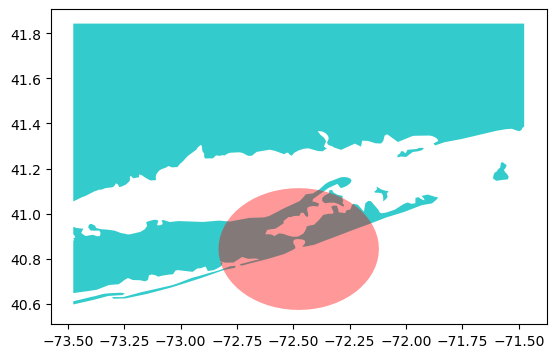

In [35]:
ax_tidal_1 = gs_region.plot(color='c', alpha=0.8)
base_gs.to_crs(gs_region.crs).plot(color='r', alpha=0.4, ax=ax_tidal_1)
ax_tidal_1.set_aspect(1)

#### Geometry object
A `GeomCollector` is created by passing the list of all rasters. We take the `10` $m$ elevation to be the domain cutoff on land.

In [36]:
geom_rasters = list()
for f in dem_paths:
    geom_rasters.append(ocsmesh.Raster(f))
    geom = ocsmesh.Geom(
        geom_rasters,
        base_shape=base_gs.unary_union,
        base_shape_crs=base_gs.crs,
        zmax=0)
    
geom_poly_tidal = geom.get_multipolygon()

/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/ops/combine_geom.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rasters_gdf = rasters_gdf.append(
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/ops/combine_geom.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rasters_gdf = rasters_gdf.append(
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/geom/collector.py:317: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(gpd.read_feather(f))


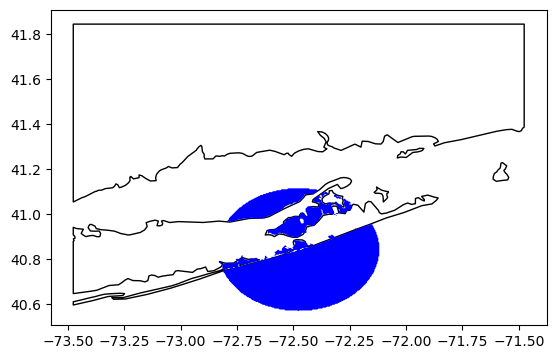

In [37]:
ax_tidal_2 = gs_region.plot(color='w', edgecolor='k')
gpd.GeoSeries(geom_poly_tidal, crs=geom.crs).plot(ax=ax_tidal_2, color='b')
ax_tidal_2.set_aspect(1)

#### Size function
Similarly for size function we use `HfunCollector`. We set the minimum size to be `200` $m$ and the maximum to be `8` $km$. Then we add a `200` $m$ element size refinement on the coastline.

In [38]:
hfun_rasters = list()
for f in dem_paths:
    hfun_rasters.append(ocsmesh.Raster(f))
hfun = ocsmesh.Hfun(
    hfun_rasters,
    base_shape=base_gs.unary_union,
    base_shape_crs=base_gs.crs,
    hmin=200, hmax=8000,
    method='fast')
hfun.add_contour(level=0, expansion_rate=0.004, target_size=200)

In [39]:
hfun_jig_tidal = hfun.msh_t()
ocsmesh.Mesh(hfun_jig_tidal).write(str(data/'tidal_hfun.2dm'), format='2dm', overwrite=True)

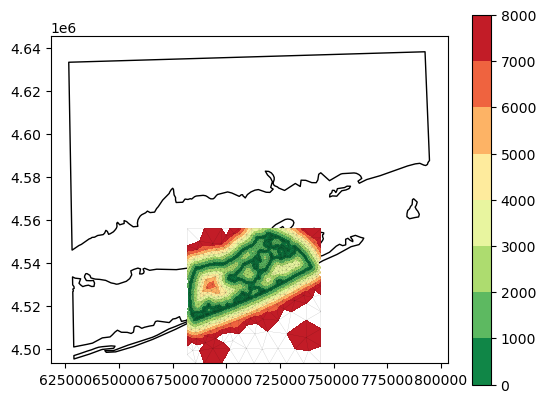

In [40]:
ax_tidal_3 = gs_region.to_crs(hfun_jig_tidal.crs).plot(color='w', edgecolor='k')
plot_mesh_vals(hfun_jig_tidal, ax=ax_tidal_3, cmap='RdYlGn_r')
plot_mesh_edge(hfun_jig_tidal, ax=ax_tidal_3, lw=0.05, color='k')

ax_tidal_3.set_aspect(1)

#### Mesh generation
Finally we generate the mesh, interpolate elevation data and extract boundaries.

In [41]:
driver = ocsmesh.JigsawDriver(geom=geom, hfun=hfun)
mesh = driver.run()

/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/ops/combine_geom.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rasters_gdf = rasters_gdf.append(
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/ops/combine_geom.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rasters_gdf = rasters_gdf.append(
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/geom/collector.py:317: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(gpd.read_feather(f))


In [42]:
interp_rasters = list()
for f in dem_paths:
    interp_rasters.append(ocsmesh.Raster(f))
mesh.interpolate(interp_rasters)

This is how the mesh and elevation contours look like:

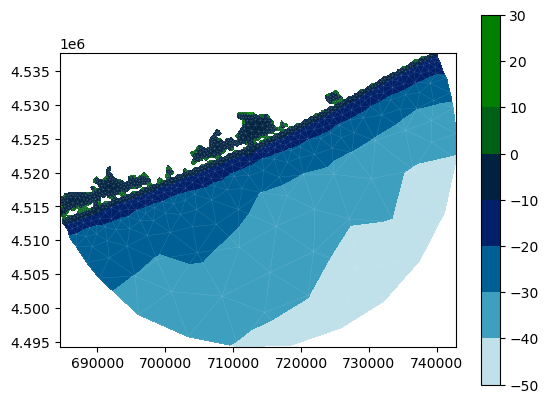

In [43]:
#ax_tidal_4 = gs_region.to_crs(mesh.msh_t.crs).plot(color='w', edgecolor='k')
fig_tidal_4, ax_tidal_4 = plt.subplots()
plot_mesh_vals(mesh.msh_t, ax=ax_tidal_4, cmap='ocean_r', vmin=-50, vmax=10)
plot_mesh_edge(mesh.msh_t, ax=ax_tidal_4, lw=0.05, color='w')

ax_tidal_4.set_aspect(1)

We detect open/land boundaries with a threshold of `-10` $m$ elevation.

In [44]:
mesh.boundaries.auto_generate(-10)

/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/mesh/mesh.py:1806: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in polys:
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/mesh/mesh.py:1875: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in polys:


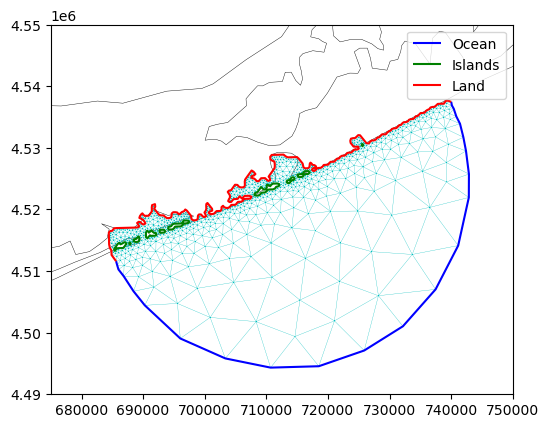

In [45]:
ax_tidal_5 = gs_region.to_crs(hfun_jig_tidal.crs).plot(color='w', edgecolor='k', lw=0.3)
plot_mesh_edge(mesh.msh_t, ax=ax_tidal_5, lw=0.2, color='c')

mesh.boundaries.ocean().plot(ax=ax_tidal_5, color='b', label='Ocean')
mesh.boundaries.interior().plot(ax=ax_tidal_5, color='g', label='Islands')
mesh.boundaries.land().plot(ax=ax_tidal_5, color='r', label='Land')
plt.legend()

ax_tidal_5.set_xlim([6.75e5, 7.5e5])
ax_tidal_5.set_ylim([4.49e6, 4.55e6])
ax_tidal_5.set_aspect(1)

Now we can write the mesh in `grd` format to be used by `pyschism` for model setup.

In [46]:
mesh.write(data/'tidal_mesh.gr3', format='grd', overwrite=True)

#### Model setup
Let's set up SCHISM model now:

In [47]:
hgrid = pyschism.mesh.Hgrid.open(data/'tidal_mesh.gr3', crs=4326)

In [48]:
dramp = timedelta(days=1.)
    
fgrid = pyschism.mesh.ManningsN.linear_with_depth(
    hgrid,
    min_value=0.02, max_value=0.05,
    min_depth=-1.0, max_depth=-3.0)

config = pyschism.driver.ModelConfig(
    hgrid=hgrid,
    fgrid=fgrid,
    iettype=pyschism.forcing.bctides.iettype.Iettype3(database="tpxo"),
    ifltype=pyschism.forcing.bctides.ifltype.Ifltype3(database="tpxo"),
    )

coldstart = config.coldstart(
    start_date=datetime.now() - timedelta(days=5.),
    end_date=datetime.now(),
    timestep=timedelta(seconds=150),
    dramp=dramp,
    dramp_ss=dramp,
    drampwind=dramp,
    nspool=timedelta(hours=1),
    elev=True,
    dahv=True,
    )

coldstart.write(data/'tidal.schism.dir', overwrite=True)

## Tools
### Parsers
### Raster manipulation
### Mesh object manipulation